# Introduction to Autoencoder and Variational Autoencoder

## Prerequisites

### Knowledge
- http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/
- http://kvfrans.com/variational-autoencoders-explained/
- https://arxiv.org/pdf/1606.05908.pdf
- https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

import tensorflow_datasets as tfds

### Data

In [2]:
dataset, info = tfds.load('mnist', data_dir='gs://tfds-data/datasets', with_info=True, as_supervised=True)
mnist_train = dataset['train']
mnist_test = dataset['test']

def convert_types(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

batch_size = 100
mnist_train = mnist_train.map(convert_types).shuffle(42*batch_size).batch(batch_size)
mnist_test = mnist_test.map(convert_types).batch(batch_size)

## What is a Autoencoder

## Autoencoder vs Variational Autoencoder (VAE)

## Implementation of a Variational Autoencoder

### Encoder

In [3]:
class Encoder(tf.keras.layers.Layer):
    
    def __init__(self, intermediate_dim, latent_dim):
        super(Encoder, self).__init__()
        
        self.h = tf.keras.layers.Dense(intermediate_dim, activation='relu', name="encoding")
        # defining the mean of the latent space
        self.z_mean = tf.keras.layers.Dense(latent_dim, name="mean")
        # defining the log variance of the latent space
        self.z_log_var = tf.keras.layers.Dense(latent_dim, name="log-variance")
        
        self.z = tf.keras.layers.Lambda(self.sampling, output_shape=(latent_dim,))
        self.latent_dim = latent_dim

    def call(self, x):
        h = self.h(x)
        
        z_mean = self.z_mean(h)
        z_log_var = self.z_log_var(h)
        
        z = self.z([z_mean, z_log_var])
        return z, [z_mean, z_log_var]

    def sampling(self, args: tuple):
        # we grab the variables from the tuple
        z_mean, z_log_var = args
        epsilon = np.random.normal(loc=0.0, scale=1.0, size=(z_mean.shape[0], self.latent_dim))
        return z_mean + tf.math.exp(z_log_var / 2) * epsilon

### Decoder

In [4]:
class Decoder(tf.keras.layers.Layer):
    
    def __init__(self, intermediate_dim, original_dim):
        super(Decoder, self).__init__()
        
        # taking the latent space to intermediate dimension
        self.h = tf.keras.layers.Dense(intermediate_dim, activation='relu', name="decoder")
        # getting the mean from the original dimension
        self.decoded = tf.keras.layers.Dense(original_dim, activation='sigmoid', name="decoded")
        
    def call(self, x):
        h = self.h(x)
        decoded = self.decoded(h)
        return decoded

### VAE Model

In [5]:
class VAE(tf.keras.Model):
    
    def __init__(self, latent_dim, intermediate_dim, original_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(intermediate_dim=intermediate_dim, latent_dim=latent_dim)
        self.decoder = Decoder(intermediate_dim=intermediate_dim, original_dim=original_dim)
        
    def call(self, x):
        out_encoder, [self.z_mean, self.z_log_var]  = self.encoder(x)
        out_decoder = self.decoder(out_encoder)
        return out_decoder

    def get_loss(self, x: tf.Tensor, x_decoded_mean: tf.Tensor):
        xent_loss = 1000 * tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
        kl_loss = -0.5 * tf.reduce_sum(1 + self.z_log_var - tf.math.square(self.z_mean) - tf.math.exp(self.z_log_var), axis=-1)
        return tf.reduce_mean(xent_loss + kl_loss) #vae loss

### Training

In [6]:
vae = VAE(2, 256, 784)
optimizer = tf.keras.optimizers.RMSprop()

In [7]:
@tf.function
def train_step(images):
    with tf.GradientTape() as tape:
        predictions = vae(images)
        loss = vae.get_loss(images, predictions)
        gradients = tape.gradient(loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    return loss

In [8]:
EPOCHS = 50

for epoch in range(EPOCHS):
    losses = []
    for image, label in mnist_train:
        image = tf.reshape(image, [batch_size, 784])
        loss = train_step(image)
        losses.append(loss)
    print("epoch", epoch, "loss", np.mean(losses))

epoch 0 loss 241.61258
epoch 1 loss 217.19562
epoch 2 loss 213.07964
epoch 3 loss 209.53928
epoch 4 loss 207.08557
epoch 5 loss 205.32631
epoch 6 loss 203.90363
epoch 7 loss 202.6505
epoch 8 loss 201.48906
epoch 9 loss 200.49112
epoch 10 loss 199.58687
epoch 11 loss 198.79553
epoch 12 loss 198.0672
epoch 13 loss 197.42513
epoch 14 loss 196.82726
epoch 15 loss 196.32066
epoch 16 loss 195.84389
epoch 17 loss 195.39322
epoch 18 loss 194.98198
epoch 19 loss 194.5852
epoch 20 loss 194.21883
epoch 21 loss 193.84113
epoch 22 loss 193.52953
epoch 23 loss 193.17795
epoch 24 loss 192.86829
epoch 25 loss 192.59283
epoch 26 loss 192.3033
epoch 27 loss 192.00745
epoch 28 loss 191.76524
epoch 29 loss 191.50578
epoch 30 loss 191.307
epoch 31 loss 191.06364
epoch 32 loss 190.85257
epoch 33 loss 190.65303
epoch 34 loss 190.43416
epoch 35 loss 190.25534
epoch 36 loss 190.04274
epoch 37 loss 189.89139
epoch 38 loss 189.71898
epoch 39 loss 189.57675
epoch 40 loss 189.44424
epoch 41 loss 189.24904
epoch 42

### Visualization

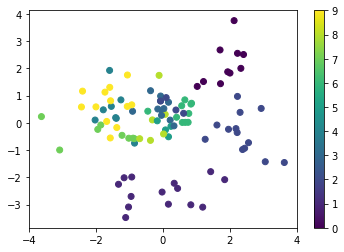

In [9]:
for image, label in mnist_test:
    image = tf.reshape(image, [-1, 784])
    x_test_encoded, _ = vae.encoder(image)
    plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=label, cmap='viridis')
    plt.colorbar()
    plt.show()
    break

In [10]:
def plot_single_sample(sample):
    prediction = vae.decoder(sample)
    digit = prediction.numpy().reshape(28, 28)
    plt.imshow(digit)
    plt.show()

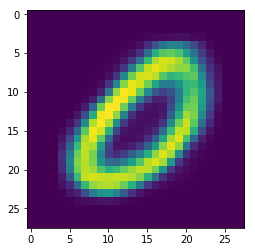

In [11]:
sample = np.array([[2, 1.5]])
plot_single_sample(sample)

In [12]:
def plot_multiple_samples(n_samples, min_val=0.05, max_val=0.95):
    # display a 2D manifold of the digits
    digit_size = 28
    figure = np.zeros((digit_size * n_samples, digit_size * n_samples))
    
    # linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
    # to produce values of the latent variables z, since the prior of the latent space is Gaussian
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n_samples))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n_samples))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder(z_sample)
            digit = x_decoded.numpy()[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
            
    plt.figure(figsize=(n_samples, n_samples))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

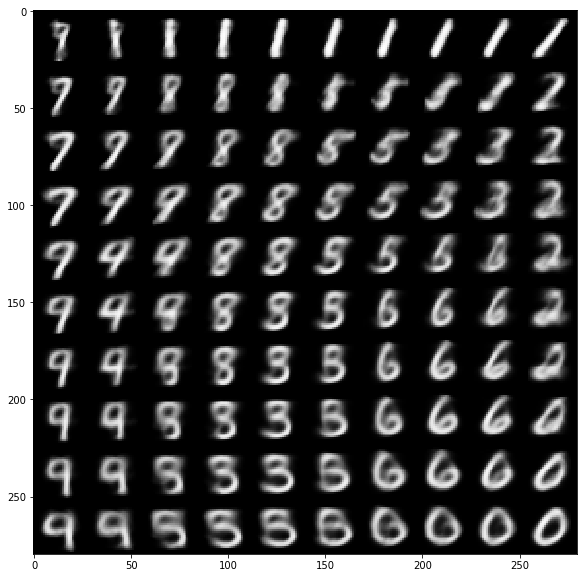

In [13]:
plot_multiple_samples(10)